In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
info_job_level_dfs = {}
info_job_level_dfs["gpu_utilization"] = pd.read_csv("job_level_gpu_utilization.csv")

gputil_all = info_job_level_dfs["gpu_utilization"]

In [3]:
submit_lines_df = pd.read_csv("submitline_information.csv")

dl_keywords = [
    'epoch', 'training', 'neural', 'cnn', 'rnn', 'lstm',
    'transformer', 'bert', 'tensorflow', 'pytorch', 'keras', 'deep',
    'machine', 'inference', 'autoencoder',
    'classification', 'detection', 'activation', 'sklearn'
]

gputil_with_submit_lines = pd.merge(gputil_all, submit_lines_df, on='jobid', how='left')

dl_keyword_pattern = '|'.join(dl_keywords)
gputil_with_submit_lines['contains_dl_keyword'] = gputil_with_submit_lines['SubmitLine'].str.contains(dl_keyword_pattern, case=False, regex=True)

dl_job_count = gputil_with_submit_lines['contains_dl_keyword'].sum()
total_jobs_with_submit_lines = len(gputil_with_submit_lines[gputil_with_submit_lines["SubmitLine"].notna()])
nondl_job_count = total_jobs_with_submit_lines - dl_job_count

jobs_with_submit_lines = gputil_with_submit_lines[gputil_with_submit_lines["SubmitLine"].notna()]
dl_jobs_df = jobs_with_submit_lines[jobs_with_submit_lines["contains_dl_keyword"] == True]
nondl_jobs_df = jobs_with_submit_lines[jobs_with_submit_lines["contains_dl_keyword"] == False]

dl_jobids = list(dl_jobs_df["jobid"])
nondl_jobids = list(nondl_jobs_df["jobid"])

gputil_dl_jobs = gputil_all[gputil_all["jobid"].isin(dl_jobids)]
gputil_nondl_jobs = gputil_all[gputil_all["jobid"].isin(nondl_jobids)]


/tmp/ipykernel_369720/2908369997.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gputil_dl_jobs['utilization_bin'] = pd.cut(gputil_dl_jobs['mean_utilization'], bins=bins_custom, labels=bin_labels_custom, right=False)
/tmp/ipykernel_369720/2908369997.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dl_jobs_normalized = gputil_dl_jobs.groupby('utilization_bin').size() / len(gputil_dl_jobs)
/tmp/ipykernel_369720/2908369997.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

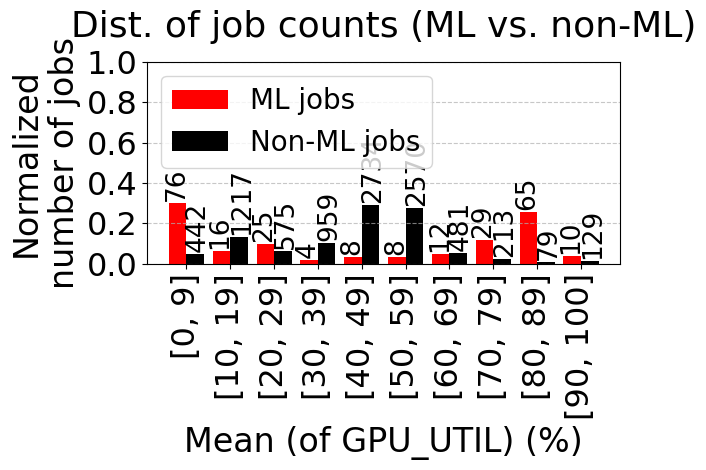

In [4]:
bins_custom = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 101]
bin_labels_custom = [f"[{bins_custom[i]}, {bins_custom[i+1] - 1}]" for i in range(len(bins_custom) - 1)]

gputil_dl_jobs['utilization_bin'] = pd.cut(gputil_dl_jobs['mean_utilization'], bins=bins_custom, labels=bin_labels_custom, right=False)
dl_jobs_normalized = gputil_dl_jobs.groupby('utilization_bin').size() / len(gputil_dl_jobs)
dl_jobs_normalized = dl_jobs_normalized.reindex(bin_labels_custom, fill_value=0)

gputil_nondl_jobs['utilization_bin'] = pd.cut(gputil_nondl_jobs['mean_utilization'], bins=bins_custom, labels=bin_labels_custom, right=False)
nondl_jobs_normalized = gputil_nondl_jobs.groupby('utilization_bin').size() / len(gputil_nondl_jobs)
nondl_jobs_normalized = nondl_jobs_normalized.reindex(bin_labels_custom, fill_value=0)

fig, ax1 = plt.subplots()

dl_positions = range(len(bin_labels_custom))  # Positions for DL bars
dl_bars = ax1.bar(
    dl_positions, 
    dl_jobs_normalized, 
    tick_label=bin_labels_custom,
    color="red", 
    alpha=1, 
    label='ML jobs', 
    width=-0.4, 
    align='edge'
)

nondl_positions = [x + 0.4 for x in dl_positions]  # Shift Non-DL bars
nondl_bars = ax1.bar(
    nondl_positions, 
    nondl_jobs_normalized,
    color="black", 
    alpha=1, 
    label='Non-ML jobs', 
    width=-0.4, 
    align='edge'
)

for bar, raw_value in zip(dl_bars, gputil_dl_jobs.groupby('utilization_bin').size().reindex(bin_labels_custom, fill_value=0)):
    ax1.text(
        bar.get_x() + bar.get_width() / 1.8, 
        bar.get_height() + 0.01, 
        f"{int(raw_value)}", 
        ha='center', 
        va='bottom', 
        fontsize=19,
        rotation=90
    )

for bar, raw_value in zip(nondl_bars, gputil_nondl_jobs.groupby('utilization_bin').size().reindex(bin_labels_custom, fill_value=0)):
    ax1.text(
        bar.get_x() + bar.get_width() / 3, 
        bar.get_height() + 0.01, 
        f"{int(raw_value)}", 
        ha='center', 
        va='bottom', 
        fontsize=19,
        rotation=90
    )

ax1.set_xlabel('Mean (of GPU_UTIL) (%)', fontsize=24)
ax1.set_ylabel('Normalized\nnumber of jobs', fontsize=24)
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.legend(loc="upper left", fontsize=20) 
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=90, labelsize=23)
ax1.tick_params(axis='y', labelsize=23)

plt.title("Dist. of job counts (ML vs. non-ML)", fontsize=26, pad=18)
plt.tight_layout()
plt.show()


/tmp/ipykernel_369720/3986687303.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gpu_hours_per_bin = dataset.groupby('utilization_bin')['gpu_hours'].sum()
/tmp/ipykernel_369720/3986687303.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gpu_hours_per_bin = dataset.groupby('utilization_bin')['gpu_hours'].sum()
/tmp/ipykernel_369720/3986687303.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bar, raw_value i

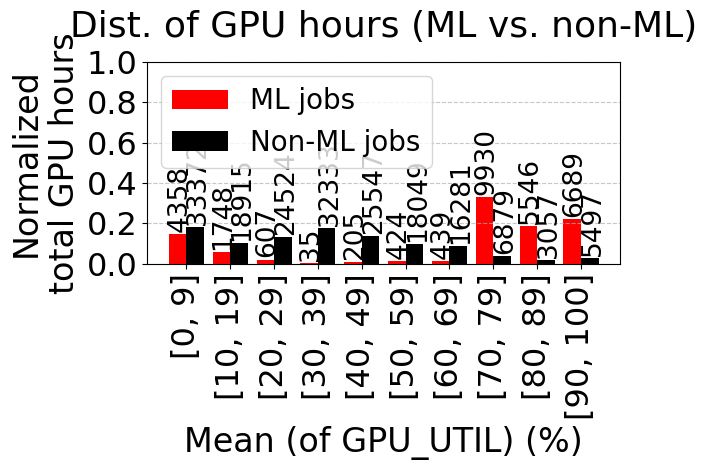

In [5]:
def calculate_normalized_gpu_hours_and_cdf(dataset):
    gpu_hours_per_bin = dataset.groupby('utilization_bin')['gpu_hours'].sum()
    gpu_hours_per_bin = gpu_hours_per_bin.reindex(bin_labels_custom, fill_value=0)
    total_gpu_hours = gpu_hours_per_bin.sum()
    normalized_gpu_hours = gpu_hours_per_bin / total_gpu_hours  
    cumulative_gpu_hours = normalized_gpu_hours.cumsum()
    cdf_gpu_hours = cumulative_gpu_hours * 100 
    return normalized_gpu_hours, cdf_gpu_hours

dl_normalized_gpu_hours, dl_cdf_gpu_hours = calculate_normalized_gpu_hours_and_cdf(gputil_dl_jobs)

nondl_normalized_gpu_hours, nondl_cdf_gpu_hours = calculate_normalized_gpu_hours_and_cdf(gputil_nondl_jobs)

fig, ax1 = plt.subplots()

dl_positions = range(len(bin_labels_custom))  # Positions for DL bars
dl_bars = ax1.bar(
    dl_positions, 
    dl_normalized_gpu_hours, 
    tick_label=bin_labels_custom,
    color="red", 
    alpha=1, 
    label='ML jobs', 
    width=-0.4, 
    align='edge'
)

nondl_positions = [x + 0.4 for x in dl_positions]
nondl_bars = ax1.bar(
    nondl_positions, 
    nondl_normalized_gpu_hours,
    color="black", 
    alpha=1, 
    label='Non-ML jobs', 
    width=-0.4, 
    align='edge'
)

for bar, raw_value in zip(dl_bars, gputil_dl_jobs.groupby('utilization_bin')['gpu_hours'].sum().reindex(bin_labels_custom, fill_value=0)):
    ax1.text(
        bar.get_x() + bar.get_width() / 2.5, 
        bar.get_height() + 0.01, 
        f"{int(raw_value)}", 
        ha='center', 
        va='bottom', 
        fontsize=19,
        rotation=90 
    )

for bar, raw_value in zip(nondl_bars, gputil_nondl_jobs.groupby('utilization_bin')['gpu_hours'].sum().reindex(bin_labels_custom, fill_value=0)):
    ax1.text(
        bar.get_x() + bar.get_width() / 3.2, 
        bar.get_height() + 0.01, 
        f"{int(raw_value)}", 
        ha='center', 
        va='bottom', 
        fontsize=19,
        rotation=90 
    )

ax1.set_xlabel('Mean (of GPU_UTIL) (%)', fontsize=24)
ax1.set_ylabel('Normalized\ntotal GPU hours', fontsize=24)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=90, labelsize=23)
ax1.tick_params(axis='y', labelsize=23)

ax1.legend(loc="upper left", fontsize=20) 

ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title("Dist. of GPU hours (ML vs. non-ML)", fontsize=26, pad=18)
plt.tight_layout()
plt.show()
